# Оценка произношения китайского языка

Этот ноутбук выполняет:
- Распознавание речи (ASR) с помощью Whisper
- Преобразование эталонного и распознанного текста в пиньинь с тонами
- Сравнение произношения по слогам
- Формирование обратной связи
- Простейшую визуализацию F0

> Для точного анализа тонов требуется **временное выравнивание** (например, через Montreal Forced Aligner). В этом ноутбуке используется упрощённый подход на основе текстового выравнивания.

In [3]:
# Установка зависимостей (запустите один раз)
!pip install openai-whisper pypinyin praat-parselmouth matplotlib numpy librosa

In [27]:
# Импорты
import pandas as pd
import whisper
import torch
from pypinyin import pinyin, Style
import difflib
import parselmouth
import numpy as np
import matplotlib.pyplot as plt
import os

In [28]:
# Загрузка данных
# Пример: сохраните ваши данные в 'dataset.csv'
df = pd.read_csv('dataset/dataset.csv', sep=';')
df.head()

,audio_filename,transcribition,transcription
0,dataset/audio/call_to_arms_0002.wav,使精神的丝缕还牵着己逝的寂寞的时光，又有什么意味呢，而我偏苦于不能全忘却,shi3 jing1 shen5 di4 si1 lv4 huan2 qian1 zhao2...
1,dataset/audio/call_to_arms_0003.wav,这不能全忘的一部分，到现在便成了《呐喊》的来由。我有四年多，曾经常常,zhè bù néng quán wàng dì yī bù fen ， dào xiàn ...
2,dataset/audio/call_to_arms_0004.wav,——几乎是每天，出入于质铺和药店里,— — jī hū shì měi tiān ， chū rù yú zhí pù hé y...


In [29]:
# Инициализация Whisper
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
asr_model = whisper.load_model("small", device=device)

Using device: cpu


In [30]:
def transcribe_audio(audio_path):
    """Распознаёт речь из аудиофайла (только китайские иероглифы)"""
    if not os.path.exists(audio_path):
        raise FileNotFoundError(f"Audio file not found: {audio_path}")
    result = asr_model.transcribe(audio_path, language="zh")
    return result["text"].strip()

In [31]:
def text_to_pinyin(text):
    """Преобразует текст на китайском в список пиньиня с тонами (формат: 'ni3')"""
    py_list = pinyin(text, style=Style.TONE3, heteronym=False)
    return [item[0] for item in py_list if item[0].strip()]

In [32]:
def align_pinyin(ref, hyp):
    """Выравнивает два списка пиньиня и помечает ошибки"""
    matcher = difflib.SequenceMatcher(None, ref, hyp)
    aligned = []
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == 'equal':
            for k in range(i2 - i1):
                aligned.append((ref[i1 + k], hyp[j1 + k], 'correct'))
        elif tag == 'replace':
            for k in range(max(i2 - i1, j2 - j1)):
                r = ref[i1 + k] if i1 + k < i2 else '<MISS>'
                h = hyp[j1 + k] if j1 + k < j2 else '<MISS>'
                aligned.append((r, h, 'error'))
        elif tag == 'delete':
            for k in range(i2 - i1):
                aligned.append((ref[i1 + k], '<NOT_SPOKEN>', 'missing'))
        elif tag == 'insert':
            for k in range(j2 - j1):
                aligned.append(('<EXTRA>', hyp[j1 + k], 'extra'))
    return aligned

In [33]:
def extract_f0(audio_path, time_step=0.01):
    """Извлекает F0-кривую из аудио"""
    snd = parselmouth.Sound(audio_path)
    pitch = snd.to_pitch(time_step=time_step)
    times = pitch.xs()
    f0 = pitch.selected_array['frequency']
    return times, f0

In [34]:
def evaluate_pronunciation(audio_path, ref_text, ref_pinyin_str):
    """Основная функция оценки произношения"""
    # ASR
    hyp_text = transcribe_audio(audio_path)

    # Пиньинь
    ref_pinyin = ref_pinyin_str.strip().split()
    hyp_pinyin = text_to_pinyin(hyp_text)

    # Выравнивание
    aligned = align_pinyin(ref_pinyin, hyp_pinyin)

    # Метрики
    total_ref = len(ref_pinyin)
    correct = sum(1 for r, h, s in aligned if s == 'correct')
    tone_accuracy = correct / total_ref if total_ref > 0 else 0.0

    # Обратная связь
    feedback = []
    for r, h, status in aligned:
        if status != 'correct':
            feedback.append(f"Ожидалось '{r}', сказано '{h}' → {status}")

    return {
        'audio': audio_path,
        'ref_text': ref_text,
        'hyp_text': hyp_text,
        'ref_pinyin': ref_pinyin,
        'hyp_pinyin': hyp_pinyin,
        'tone_accuracy': round(tone_accuracy, 3),
        'feedback': feedback,
        'aligned': aligned
    }

In [35]:
def plot_f0_curve(audio_path):
    """Простая визуализация F0"""
    times, f0 = extract_f0(audio_path)
    plt.figure(figsize=(12, 3))
    plt.plot(times, f0, color='steelblue')
    plt.title(f"F0 Curve: {os.path.basename(audio_path)}")
    plt.xlabel("Time (s)")
    plt.ylabel("F0 (Hz)")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

/usr/local/lib/python3.12/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


=== РЕЗУЛЬТАТЫ ===
Эталонный текст: 使精神的丝缕还牵着己逝的寂寞的时光，又有什么意味呢，而我偏苦于不能全忘却
Распознано:      使精神的思旅還牽著已世的寂寞的時光,又有什麼意味呢?而我偏苦於不能全忘卻。
Точность тонов: 69.4%

Ошибки:
- Ожидалось 'shen5', сказано 'shen2' → error
- Ожидалось 'di4', сказано 'de' → error
- Ожидалось 'lv4', сказано 'lv3' → error
- Ожидалось 'huan2', сказано 'hai2' → error
- Ожидалось 'zhao2', сказано 'zhu4' → error
- Ожидалось 'ji3', сказано 'yi3' → error
- Ожидалось 'di4', сказано 'de' → error
- Ожидалось 'di4', сказано 'de' → error
- Ожидалось '，', сказано ',' → error
- Ожидалось 'ni2', сказано 'ne' → error
- Ожидалось '，', сказано '?' → error
- Ожидалось '<EXTRA>', сказано '。' → extra


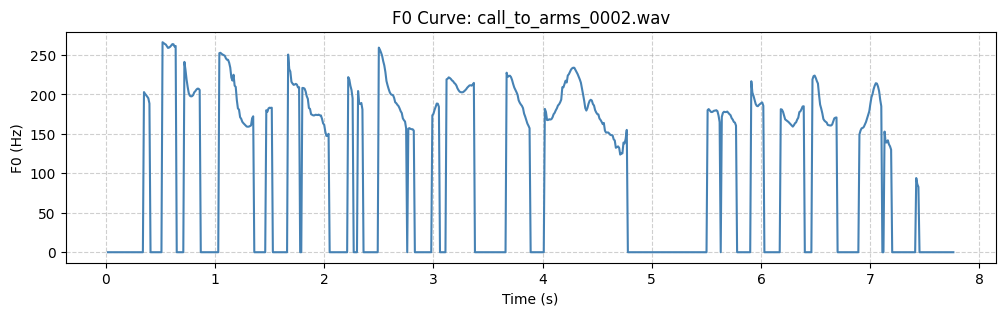

In [36]:
# Пример обработки первой строки датасета
row = df.iloc[0]
result = evaluate_pronunciation(row['audio_filename'], row['transcribition'], row['transcription'])

print("=== РЕЗУЛЬТАТЫ ===")
print(f"Эталонный текст: {result['ref_text']}")
print(f"Распознано:      {result['hyp_text']}")
print(f"Точность тонов: {result['tone_accuracy'] * 100:.1f}%")
print("\nОшибки:")
for msg in result['feedback']:
    print("-", msg)

# Визуализация F0
plot_f0_curve(row['audio_filename'])

## Замечания

- **Whisper не различает тона**: он выдаёт только иероглифы. Если иероглиф распознан правильно — считаем, что тон верен.
- **Точное сравнение тонов требует временного выравнивания слогов** , можно использовать [Montreal Forced Aligner](https://montreal-forced-aligner.readthedocs.io/) для продвинутого анализа.
- Для массовой обработки оберните вызов `evaluate_pronunciation` в цикл по `df.iterrows()`.
- Чтобы оценивать **темп речи**, нужно добавить `len(hyp_text) / duration(audio)`.
- Для **грамматики/лексики** можно использовать китайские NLP-модели (например, LTP, HanLP).